<center><font size="7">Fit multi-variables</font></center>





<font size="4">Copyright Christophe PERE 01/05/2017</font>

<span style="color:red"><font size="6">I - Clean Data</font></span>

In [3]:
%matplotlib inline       
#%matplotlib notebook
# Mandatory in jupyter's notebook if you want to see your plot
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import math as M
from scipy.optimize import curve_fit
from time import mktime
from scipy.optimize import leastsq
from mpl_toolkits.mplot3d import Axes3D

In [4]:
# Let's began with the site 'LaCentrale.fr' and a subdataframe with brands 'PEUGEOT, CITROEN and DS AUTOMOBILES' 
name = '../Docs/Files_FR/Etude_Christophe/car_FR_PSA_lacentrale.csv'

# Open the gzip file and convert all the data in string format, separate the columns with the delimiter ';'
df = pd.read_csv(name+'.gzip', sep=';', dtype=str, compression='gzip')     # load the csv file 

head = list(df)                                        # Get the name of the columns 
print(head)  

['data_month', 'MARQUE_CORRECTED', 'MODELE_CORRECTED', 'CARROSSERIE_CORRECTED', 'CARBURANT_CORRECTED', 'LITRE', 'PUISSANCE_CORRECTED', 'BOITE_CORRECTED', '4RM', 'PRIX', 'KM', 'ANNEE', 'MOIS', 'PORTE_CORRECTED', 'doublon_id_2', 'site']


In [5]:
def func_treatment(data, head, year):

    pd.options.mode.chained_assignment = None                       # permit to avoid error in copying 
    
    cols = [head[1], head[2],head[3],head[4]]
    for c in cols:
        data[c] = pd.to_numeric(data[c], errors='coerce')           # cast the type str to numeric
        
    # Select a part of the dataframe where the year is > at year passed in the function 
    data = data[(data[head[3]].astype(int)<=datetime.now().year) & (data[head[3]].astype(int)>=year) ]
    data = data[data[head[4]]>0]
    # ---- Date creation --------------------------------------------
    #a = data[head[4]].apply(lambda x : x if x>0 else 1)             # Month can be = 0 when not found in the crawl 
    #data[head[4]]=a.values                                          # so, it's better to fix them at 1 
    a = data[head[4]].apply(lambda x : str(x) if x>=10 else '0'+str(x))# string format and add a 0 when the month is 
    data[head[4]]=a.values                                          # < 10 (01, 02, 03...)
    
    date = data[head[3]].astype(str)+'-'+data[head[4]]              # concat the year-month to generate the Date
    data['Date'] = date.values                                      # .astype() permit to cast a type to another     
                                                                    # passed in the () 
    data_month = [i.split('/') for i in data.data_month]
    data_month = [i[2]+'-'+i[1] for i in data_month]
    data.data_month=data_month
    #print(data.data_month[:5])
    #print(data.data_month.iat[0],'%Y-%m')
    size = len(data)
    date_delta=[datetime.strptime(data.data_month.iat[i],'%Y-%m')-datetime.strptime(data.Date.iat[i],'%Y-%m') \
              for i in range(size)]
    #print(date_delta[0].days/30)
    date_age=[round(i.days/30) for i in date_delta] #round
    data['Age_months']=date_age
    data = data[data.Age_months>=0]
    # ---- Data cleaning --------------------------------------------
    a = data[head[0]].fillna(' ')
    data[head[0]] = a.values
    a = data[head[1]].apply(lambda x : x if x>0 else 0 )
    data[head[1]] = a.values
    
    return data

Select the model for the study :

In [28]:
model = 'C3' 
power = '70' 
liter = '1.4'

Make a subdataframe with different columns

In [7]:
df_carac = df[['MODELE_CORRECTED', 'PRIX', 'KM', 'ANNEE', 'MOIS','CARROSSERIE_CORRECTED', \
               'CARBURANT_CORRECTED', 'LITRE', 'PUISSANCE_CORRECTED', 'BOITE_CORRECTED',  \
               '4RM',  'PORTE_CORRECTED','data_month']]
head = list(df_carac)
print(head)

['MODELE_CORRECTED', 'PRIX', 'KM', 'ANNEE', 'MOIS', 'CARROSSERIE_CORRECTED', 'CARBURANT_CORRECTED', 'LITRE', 'PUISSANCE_CORRECTED', 'BOITE_CORRECTED', '4RM', 'PORTE_CORRECTED', 'data_month']


Now select a subdataframe concerning the model choose before

In [29]:
df_model = df_carac[df_carac[head[0]]==model]           # select a subdataframe with the model pass in part II
df_model = df_model.dropna(subset=['LITRE','PUISSANCE_CORRECTED'])
df_model = df_model[df_model[head[7]].astype(float)>0]
#df_model = df_model[df_model[head[5]]=='MONOSPACE']
#df_model = df_model[df_model[head[6]]=='DIESEL']
print(df_model[head[5]].sort_values().unique())
print(df_model[head[6]].sort_values().unique())
print(df_model[head[7]].sort_values().unique())
print(df_model[head[8]].astype(int).sort_values().unique())
df_model = df_model[df_model[head[7]]==liter]
print(len(df_model))
df_model = df_model[df_model[head[8]]==power]
print(len(df_model))

['BERLINE' 'SOCIETE']
['DIESEL' 'ELECTRIQUE' 'ESSENCE' 'ESSENCE - BIOETHANOL' 'ESSENCE - GNV'
 'ESSENCE - GPL']
['1.0' '1.1' '1.2' '1.4' '1.6' '1.7' '2.0']
[ 56  57  60  61  68  69  70  71  73  74  75  81  82  88  89  90  92  95
  99 100 108 109 110 111 114 115 119 120 149]
42240
3112


The dataframe need to be treated the function func_treatment permit to clean the data and add columns like the age and the date. 

In [30]:
year_min = 2000  
df_model = func_treatment(df_model,list(df_model),year_min)
print(df_model.head())

    MODELE_CORRECTED  PRIX      KM  ANNEE MOIS CARROSSERIE_CORRECTED  \
374               C3  6990  100825   2012   07               SOCIETE   
563               C3  7440   54986   2012   06               SOCIETE   
640               C3  6990   75402   2012   07               SOCIETE   
730               C3  6990  121400   2012   01               BERLINE   
735               C3  7490   62550   2012   04               SOCIETE   

    CARBURANT_CORRECTED LITRE PUISSANCE_CORRECTED BOITE_CORRECTED 4RM  \
374              DIESEL   1.4                  70        MANUELLE   N   
563              DIESEL   1.4                  70        MANUELLE   N   
640              DIESEL   1.4                  70        MANUELLE   N   
730              DIESEL   1.4                  70     AUTOMATIQUE   N   
735              DIESEL   1.4                  70        MANUELLE   N   

    PORTE_CORRECTED data_month     Date  Age_months  
374               5    2016-02  2012-07          44  
563               5 

In [20]:
def func_outliers(data):                                       # remove outliers from data

    years = data[head[3]].unique()                             # list of years unique
    years = list(years)
    years.sort()                                               # sort the list ascending
    t = []
    if(len(years)<3):                                          # if we have 1 or 2 years we take all the data
        return data
    for i in years :
        df = data[data[head[3]]==i]                            # select a subdataframe by year
        months = df[head[4]].unique()                          # return a list of month
        for j in months:
            df2 = df[df[head[4]]==j]                           # select a subsubdataframe by month in the year
            mean = df2[head[1]].median(axis=0)                 # compute the median of the price for the month
            std  = df2[head[1]].std(axis=0)                    # compute the standard deviation
            df_fin = df2[(df2[head[1]] < (mean+ 3* std)) ]     # select price in the interval median+/-2std
            df_fin = df_fin[(df_fin[head[1]]>(mean-3*std))]
            t.append(df_fin)                                   # create a list of subsubdataframe
        d = pd.concat(t, axis=0)                               # create a final dataframe of the points without 
                                                               # outliers
    d = d.drop_duplicates(d[['PRIX','KM','Date']],keep='last')
    d = d[d.KM<200000]
    return d

Now, it's possible to see outliers point in the data and replicates vehicles. To clarify and decrease the point's number the func_outliers delete them. 

In [31]:
df_select = func_outliers(df_model)

print(df_select[['PRIX','KM','Date','data_month','Age_months']].head(5))
print(len(df_select))

        PRIX      KM     Date data_month  Age_months
160005  3300  170486  2002-05    2016-06         172
264696  2690  197000  2002-05    2016-10         176
358747   600  180650  2002-05    2017-01         179
207716  2990  172000  2002-06    2016-08         172
236076  2590  167000  2002-06    2016-09         174
2041


The next figure is a representation of the two datasets. The price is plotted in function of the age. The blue points are the global dataset and the yellow points are the selected part. 

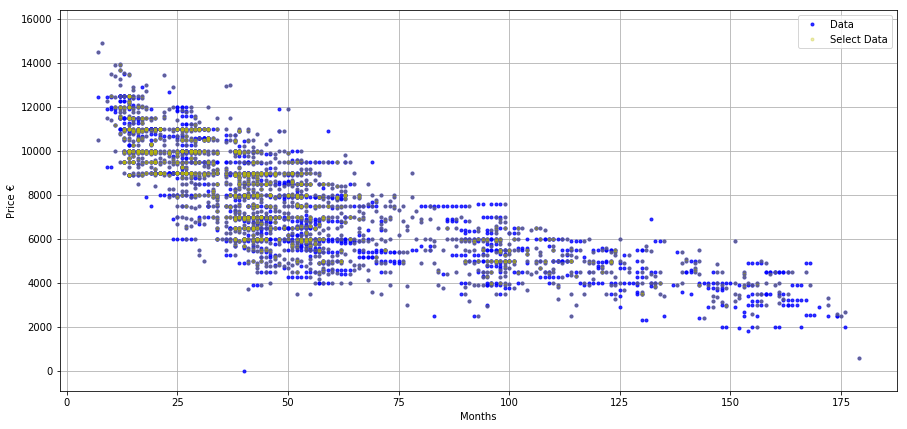

In [32]:
fig = plt.figure(figsize=(15,7))
plt.plot(df_model.Age_months, df_model.PRIX, 'b.', alpha=0.8, label='Data')
plt.plot(df_select.Age_months, df_select.PRIX, 'y.', alpha=0.3, label='Select Data')
plt.ylim(df_select.PRIX.min()-1500, df_select.PRIX.max()+1500)
plt.legend()
plt.xlabel('Months')
plt.ylabel('Price €')
plt.grid(True)

The next step is to compute value with this dataframe. Let's begin with the mean and median value and the standard deviation. 

In [33]:
def func_mean_median(data, name):
    # ---- Mean Median computation --------------------------------------------------
    
    mean = []                                # Empty list to stock the results of the computation
    median = []
    err = []
    km_value = []
    for i in data[name].unique():
        d  = data[data[name]==i]             # Select a subdataframe by date
        z  = d[head[1]].mean(axis=0)         # Compute the mean of the price
        z4 = d[head[1]].std(axis=0)          # Compute the standard deviation of the price 
        z2 = d[head[1]].median(axis=0)       # Compute the median of the price
        z3 = d[head[2]].mean(axis=0)         # Compute the mean of the kilometer
        mean.append(z)                       # Save the values in the lists 
        median.append(z2)
        err.append(z4)
        km_value.append(z3)
    # ---- Create the final dictionnary with all the results --------------------------
    dict_values = { name   :pd.Series(np.array(df_select[name].unique())),
                   'Mean'  :pd.Series(np.array(mean)),
                   'Median':pd.Series(np.array(median)),
                   'Error' :pd.Series(np.array(err)),
                   'km'    :pd.Series(np.array(km_value)) }
    
    # Pass from dict to dataframe by specifying the name of the columns - correspond to the columns' order
    df_results = pd.DataFrame(columns = [name, 'Mean','Median','Error','km'],data=dict_values) 
    return df_results

In [34]:
df_results  = func_mean_median(df_select, 'Age_months')           # Call the function 

Print the results of the mean and median between the price and the age. 

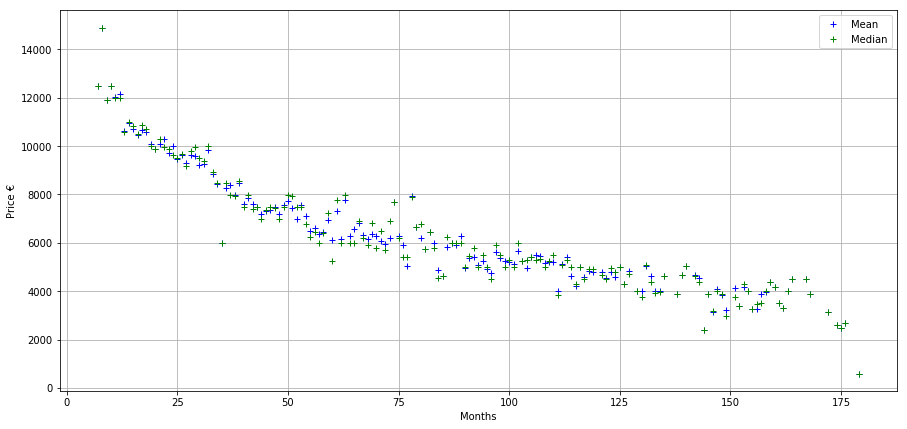

In [35]:
fig = plt.figure(figsize=(15,7))
plt.plot(df_select.Age_months.unique(), df_results.Mean, 'b+', label='Mean')
plt.plot(df_select.Age_months.unique(), df_results.Median, 'g+', label='Median')
plt.legend()
plt.xlabel('Months')
plt.ylabel('Price €')
plt.grid(True)

<span style="color:red"><font size="6">II - Multivariate fit</font></span>

Now it's time to modelise this data to create a predictive model. A feature selection shows that the km and the age of a car are the principal components to generate the price. So this two variables need to be fit. Two approaches will be tested, an exponential model and a polynomial model. 

In [36]:
def func_fitexp(x, y):                                      # fit exponential with numpy package   
    res = np.polyfit(x, np.log(y), 1,w=np.sqrt(y))
    res_tot = np.exp(res[1])*np.exp(res[0]*x)
    return res_tot, res

def func_exp(x, y):                                         # fit exponential with scipy package 
    res_fit = curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=(20000, 1e-6))
    #print(res_fit[0])
    return res_fit[0][0] * np.exp(res_fit[0][1] * x)

def func_exp2(p, x, z):                                     # exponential function with multiple parameters  
#    a, b, t, t2 = p[0], p[1], p[2], p[3]
    a, b, c, d, t, t2 = p[0], p[1], p[2], p[3], p[4], p[5]
#    return a*np.exp(b + x*t + z*t2)
    return a*np.exp(b + pow(x,c)*t + pow(z,d)*t2)

def err(p, x,z, y):                                         # error function compare the previous to the estimate to
    return func_exp2(p, x,z) - y                            # minimise the residuals 



In [37]:
def func_poly(p, x, z):                                     # polynomial function with multiple parameters
    a, t, t2, t3, t4, t5, t6 = p[0], p[1], p[2], p[3], p[4], p[5], p[6]
    return a + x*t+ z*t2 + pow(x,2)*t3 + pow(z,2)*t4 + pow(x,3)*t5 + pow(z,3)*t6

def err_poly(p, x,z, y):                                    # error function compare the previous to the estimate to
    return func_poly(p, x,z) - y                            # minimise the residuals 



Let's start with the simpliest : the polynomial fit. 

To do this, the function <i>leastsq</i> of the <i>Scipy</i> package will be used. This function is a least-square function. The parameters passed in parameters are simple, the residuals function, the first estimator parameters, and the args parameters, they are the x,y,z values. The maxfev part is a limit to the loop, if the leastsq can't converge, the loop break at the maxfev number. 

In [44]:
p1=[20000,-1e-3,1,1,1,-1e-2, -1e-6]
param, ier = leastsq(err_poly, p1, args=(df_select.Age_months,df_select.KM,df_select.PRIX), maxfev=5000000)

In [45]:
print(param)

[  1.36195161e+04  -1.15764984e+02  -4.28652110e-02   9.78300337e-01
   1.01031200e-07  -3.00174860e-03  -3.35867931e-14]


In [46]:
p0=[param[0],-1e-3,1,1,-1e-2, -1e-6]                           # First parameters 
param_exp, ier = leastsq(err, p0, args=(df_select.Age_months,df_select.KM,df_select.PRIX), maxfev=500000)
#for i in range(100):
#param_exp2, ier = leastsq(err, param_exp, args=(df_select.Age_months,df_select.KM,df_select.PRIX), maxfev=500000)
#    param_exp=param_exp2
p2=[param[0],-1e-3,1,1,-1e-2, -1e-6]                           # First parameters 
#param_exp2, ier2 = leastsq(err, p2, args=(df_select.Age_months,df_select.KM,df_select.PRIX), maxfev=500000)
pfit, pcov, infodict, errmsg, success = leastsq(err, p2, args=(df_select.Age_months,df_select.KM,df_select.PRIX), full_output=1, epsfcn=0.000001)
pfit, pcov, infodict, errmsg, success = leastsq(err, pfit, args=(df_select.Age_months,df_select.KM,df_select.PRIX), full_output=1, epsfcn=0.0000001)

print(param_exp, ier)
print(pfit)

[  1.48350849e+04   9.83531794e-02   4.71902216e-01   1.02285784e+00
  -8.28043918e-02  -2.85955811e-06] 1
[  1.59100390e+04   2.84665915e-02   4.71715360e-01   1.02339303e+00
  -8.28940798e-02  -2.84117757e-06]


Try the exponential model with different kilometers and see what's happend (good or bad behavior, if the price increase with the increase km it's bad). 

In [47]:
y_New = func_exp2(param_exp, df_results.Age_months,df_results.km)   # values of the price with the model
y_New2= func_exp2(pfit, df_results.Age_months,df_results.km)   # values of the price with the model

KMM = 100                                                           # new monthly kilometers
x_test = KMM * df_results.Age_months                                # new kilometers for the age
KMM = 5000                                                          # same
x_test2 = KMM * df_results.Age_months

y_test = func_exp2(param_exp, df_results.Age_months,x_test)         # compute the price
y_test2 = func_exp2(param_exp, df_results.Age_months,x_test2)

In [48]:
y_poly = func_poly(param, df_results.Age_months,df_results.km)      # same with the polynomial fit 

Time to plot the results and the comparaison between different kilometers. 

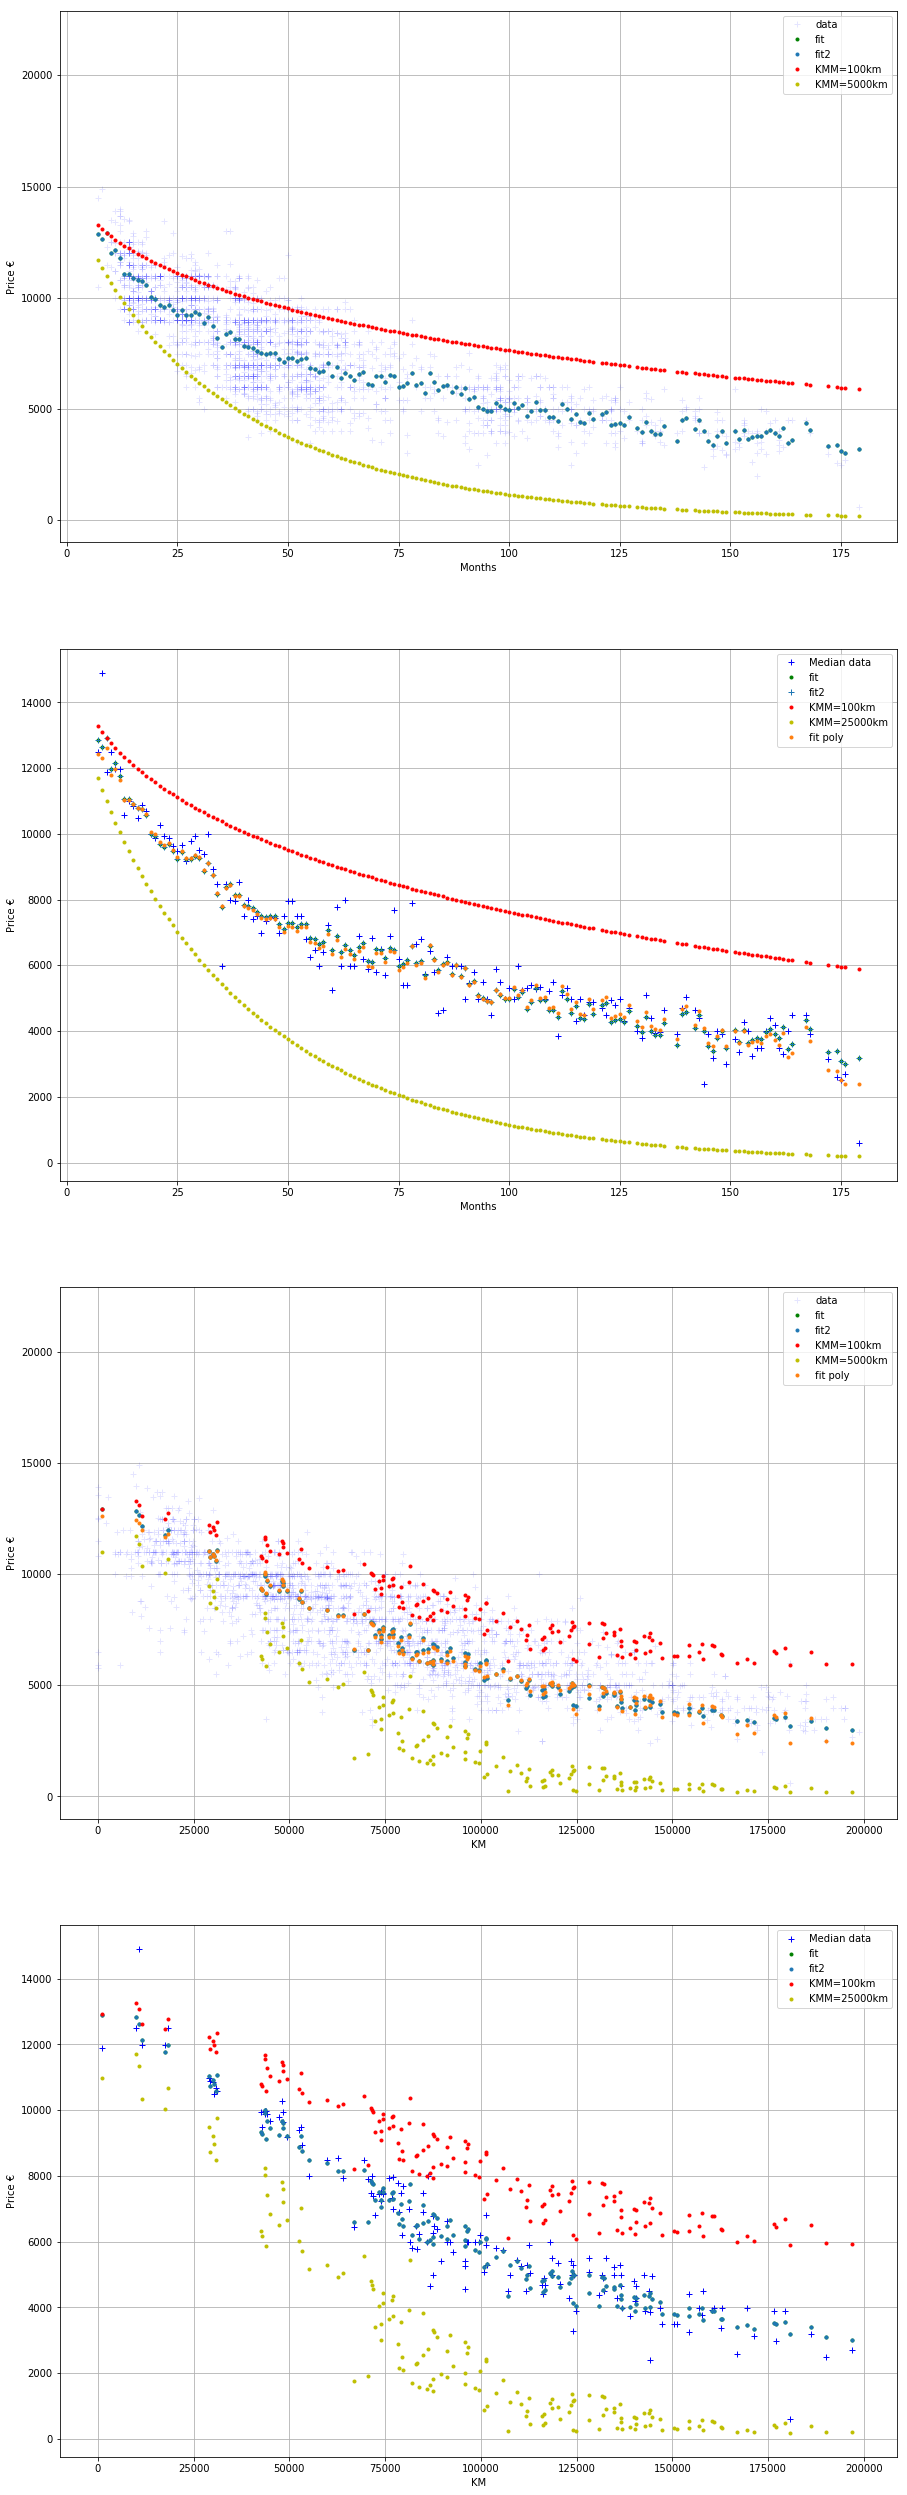

In [49]:
#df_results = df_results.sort_values(by='Age_months')
fig = plt.figure(figsize=(15,45))                                            # size of the all picture
ax1 = plt.subplot(411)                                                       # first subplot 1/4 
plt.plot(df_select.Age_months, df_select.PRIX, 'b+', alpha=0.1,label='data') # All the data, plot price = f(age)
plt.plot(df_results.Age_months, y_New, 'g.', label='fit')                    # Fit of the all data 
plt.plot(df_results.Age_months, y_New2, '.', label='fit2')                    # Fit of the all data 
plt.plot(df_results.Age_months, y_test, 'r.', label='KMM=100km')             # First test kilometers < km mean model
plt.plot(df_results.Age_months, y_test2, 'y.', label='KMM=5000km')           # Second, KMM > km mean model 
plt.ylim(-1000,np.amax(y_New)+10000)                           # resize the figure 
plt.legend()
plt.xlabel('Months')
plt.ylabel('Price €')
plt.grid(True)
ax2 = plt.subplot(412, sharex=ax1)                                           # subplot 2/4 (nb row, nb column, position)
plt.plot(df_results.Age_months, df_results.Median, 'b+',label='Median data')
plt.plot(df_results.Age_months, y_New, 'g.', label='fit')
plt.plot(df_results.Age_months, y_New2, '+', label='fit2')                    # Fit of the all data 
plt.plot(df_results.Age_months, y_test, 'r.', label='KMM=100km')
plt.plot(df_results.Age_months, y_test2, 'y.', label='KMM=25000km')
plt.plot(df_results.Age_months, y_poly, '.', label='fit poly')
plt.legend()
plt.xlabel('Months')
plt.ylabel('Price €')
plt.grid(True)
ax3 = plt.subplot(413)                                           # subplot 3/4 (nb row, nb column, position)
plt.plot(df_select.KM, df_select.PRIX, 'b+', alpha=0.1,label='data')
plt.plot(df_results.km, y_New, 'g.', label='fit')
plt.plot(df_results.km, y_New2, '.', label='fit2')                    # Fit of the all data 
plt.plot(df_results.km, y_test, 'r.', label='KMM=100km')
plt.plot(df_results.km, y_test2, 'y.', label='KMM=5000km')
plt.plot(df_results.km, y_poly, '.', label='fit poly')
plt.ylim(-1000,np.amax(y_New)+10000)
plt.legend()
plt.xlabel('KM')
plt.ylabel('Price €')
plt.grid(True)
ax4 = plt.subplot(414, sharex=ax3)                                           # subplot 4/4 (nb row, nb column, position)
plt.plot(df_results.km, df_results.Median, 'b+',label='Median data')
plt.plot(df_results.km, y_New, 'g.', label='fit')
plt.plot(df_results.km, y_New2, '.', label='fit2')                    # Fit of the all data 
plt.plot(df_results.km, y_test, 'r.', label='KMM=100km')
plt.plot(df_results.km, y_test2, 'y.', label='KMM=25000km')
plt.legend()
plt.xlabel('KM')
plt.ylabel('Price €')
plt.grid(True)

The results can be plot in 3D graph like this : 

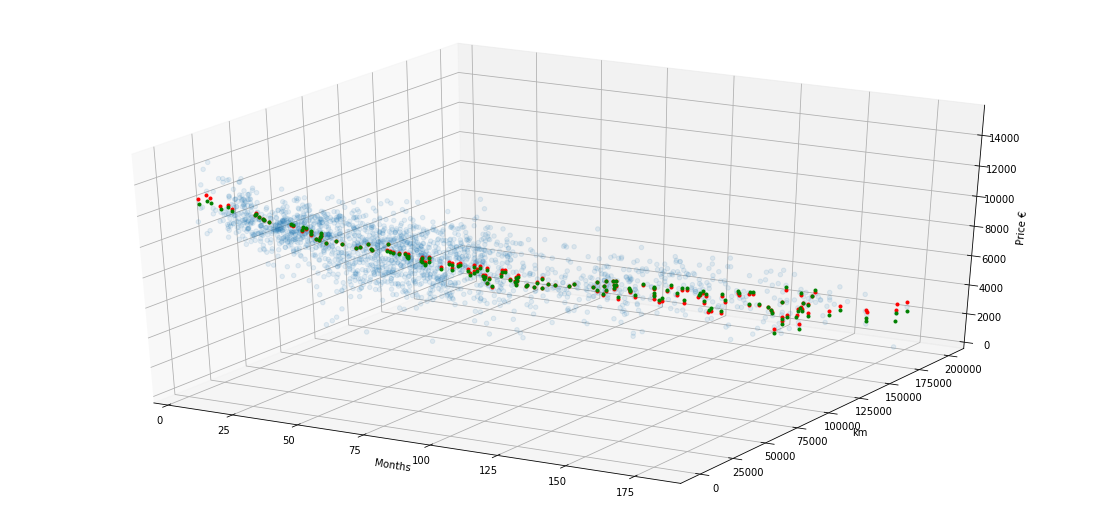

In [50]:
fig = plt.figure(figsize=(15,7))
ax = Axes3D(fig)
#threedee = plt.figure(figsize=(15,7)).gca(projection='3d')
ax.scatter(xs=df_select.Age_months, ys=df_select.KM, zs=df_select.PRIX, alpha=0.1)
ax.plot(df_results.Age_months, df_results.km,y_New, 'r.')
ax.plot(df_results.Age_months, df_results.km,y_poly, 'g.')

plt.xlabel('Months')
plt.ylabel('km')
ax.set_zlabel('Price €')
plt.grid(True)

<span style="color:red"><font size="6">III - Comparaison Actual VR</font></span>

In [51]:
# Load the file PSA computed with the VR model on the servor 
df_compa = pd.read_csv('../Docs/Fichiers_tests_VR/compa_vr_PSA.csv', dtype=str, sep=';')

In [52]:
def func_convert(data):
    cols = ['ANNEE_CORRECTED', 'MOIS', 'JOUR', 'AGE', 'KM','VR']
    for c in cols:
        data[c] = pd.to_numeric(data[c], errors='coerce')           # cast the type str to numeric
    return data

# Make the date
def func_age_vr(df):
    date_mec = [datetime(df.ANNEE_CORRECTED.iat[i], df.MOIS.iat[i], df.JOUR.iat[i]) for i in range(len(df))]
    date_VR  = [datetime.strptime(i, '%Y-%m-%d 00:00:00') for i in df.DATE_VR]
    Age_VR = [np.floor((date_VR[i] - date_mec[i]).days/30) for i in range(len(date_VR))]
    df['Age_VR']=Age_VR
    return df

In [53]:
# Select the subdataframe in the file 
df_compa = df_compa[(df_compa['MODELE_CORRECTED']==model) & (df_compa['LITRE']==liter) & \
                    (df_compa['PUISSANCE_CORRECTED']==power)]
print(len(df_compa))

4319


In [54]:
# Convert to numeric data and compute the age 
df_compa = func_convert(df_compa)
df_compa = func_age_vr(df_compa)

In [55]:
# Computation of the VR with the multi-variales model
cote_model_exp = func_exp2(pfit, df_compa.Age_VR.astype(int), df_compa.KM_VR.astype(int))
cote_model_poly= func_poly(param, df_compa.Age_VR.astype(int), df_compa.KM_VR.astype(int))
df_compa['Cote_model_exp'] =cote_model_exp
df_compa['Cote_model_poly']=cote_model_poly
df_compa = df_compa.sort_values(by='AGE')

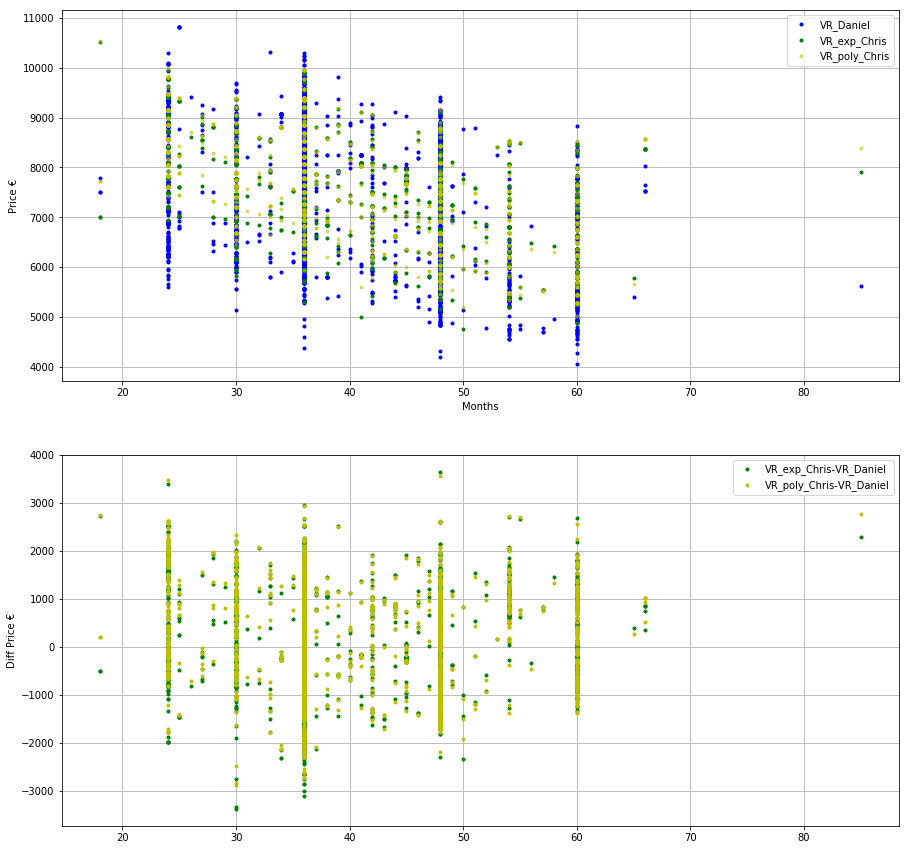

In [56]:
# plot the results of the comparaison 
fig = plt.figure(figsize=(15,15))                                            # size of the all picture
ax1 = plt.subplot(211)                                                       # first subplot 1/4 
plt.plot(df_compa.Age_VR, df_compa.VR, 'b.', label='VR_Daniel')              # All the data, plot price = f(age)
plt.plot(df_compa.Age_VR, df_compa.Cote_model_exp, 'g.', label='VR_exp_Chris')  # Fit of the all data 
plt.plot(df_compa.Age_VR, df_compa.Cote_model_poly,'y.', alpha = 0.5, label='VR_poly_Chris') # Fit of the all data 
plt.legend()
plt.xlabel('Months')
plt.ylabel('Price €')
plt.grid(True)
ax1 = plt.subplot(212)                                                       # first subplot 1/4 
plt.plot(df_compa.Age_VR, df_compa.Cote_model_exp-df_compa.VR, 'g.', label='VR_exp_Chris-VR_Daniel') 
plt.plot(df_compa.Age_VR, df_compa.Cote_model_poly-df_compa.VR, 'y.', label='VR_poly_Chris-VR_Daniel') 
plt.legend()
plt.ylabel('Diff Price €')
plt.grid(True)

In [57]:
'The mean difference between the exponential model is {}€'.format(int((df_compa.Cote_model_exp-df_compa.VR).mean()))

'The mean difference between the exponential model is -72€'

In [58]:
'The mean difference between the polynomial model is {}€'.format(int((df_compa.Cote_model_poly-df_compa.VR).mean()))

'The mean difference between the polynomial model is -47€'